Inside this new notebook:

Cell 1 → Imports + Load cleaned dataset

Minimal imports + load this file:

/content/cleaned_nypd_2022_2024.csv

Cell 2 → Basic map / sample preview

Just display a few rows or map center.

Cell 3 → KDE (Heatmap) implementation

Very simple version first.

Cell 4 → DBSCAN clustering

Small cell, straightforward.

Cell 5 → Visualize KDE or DBSCAN on a map

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import HeatMap

df = pd.read_csv("/content/cleaned_nypd_2022_2024.csv")

df.head()

,complaint_id,date,time,offense,severity,borough,precinct,lat,lon,year,month,day,weekday
0,298702504,2024-12-30,05:00:00,PETIT LARCENY,MISDEMEANOR,QUEENS,114.0,40.769926,-73.888860,2024,12,30,0
1,298695090,2024-12-30,22:00:00,HARRASSMENT 2,VIOLATION,MANHATTAN,7.0,40.711274,-73.984350,2024,12,30,0
2,298672412,2024-12-30,21:45:00,ASSAULT 3 & RELATED OFFENSES,MISDEMEANOR,BROOKLYN,78.0,40.678520,-73.983808,2024,12,30,0
3,298698005,2024-12-30,17:00:00,CRIMINAL MISCHIEF & RELATED OF,MISDEMEANOR,QUEENS,111.0,40.740316,-73.759881,2024,12,30,0
4,298685372,2024-12-30,00:30:00,PETIT LARCENY,MISDEMEANOR,QUEENS,105.0,40.750884,-73.717741,2024,12,30,0


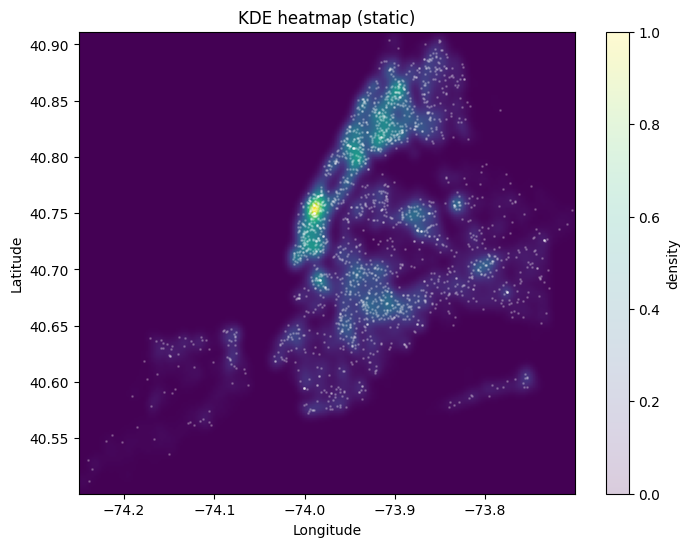

In [7]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

n_sample = 50000
if df.shape[0] > n_sample:
    sample = df.sample(n_sample, random_state=1)
else:
    sample = df.copy()

lats = sample['lat'].values
lons = sample['lon'].values
coords = np.column_stack([lats, lons])  # KDE on (lat, lon)

# fit KDE
bw = 0.005   # ~0.5 km rough scale — change later if required
kde = KernelDensity(bandwidth=bw, metric='haversine' if False else 'euclidean')
kde.fit(coords)

min_lat, max_lat = lats.min(), lats.max()
min_lon, max_lon = lons.min(), lons.max()

nx, ny = 200, 200
xi = np.linspace(min_lat, max_lat, nx)
yi = np.linspace(min_lon, max_lon, ny)
xx, yy = np.meshgrid(xi, yi)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

log_dens = kde.score_samples(grid_points)
dens = np.exp(log_dens).reshape(nx, ny)

plt.figure(figsize=(8,6))
plt.imshow(dens.T, origin='lower',
           extent=[min_lon, max_lon, min_lat, max_lat],
           aspect='auto')
plt.scatter(lons[:2000], lats[:2000], s=1, alpha=0.2, c='white')  # small sample overlay
plt.title('KDE heatmap (static)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='density')
plt.show()

center = [(min_lat+max_lat)/2, (min_lon+max_lon)/2]
m = folium.Map(location=center, zoom_start=11)
pts = sample[['lat','lon']].values.tolist()
HeatMap(pts, radius=8, blur=12, max_zoom=13).add_to(m)

m

In [3]:
# DBSCAN clustering on lat/lon

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

sample_size = 50000
if df.shape[0] > sample_size:
    df_db = df.sample(sample_size, random_state=1)[['lat','lon']].copy()
else:
    df_db = df[['lat','lon']].copy()

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_db[['lat','lon']])

db = DBSCAN(eps=0.05, min_samples=50)
clusters = db.fit_predict(coords_scaled)

df_db['cluster'] = clusters

df_db['cluster'].value_counts()

,count
cluster,
0,20289
-1,10108
4,7757
6,2137
2,1164
3,1021
8,932
1,653
9,476


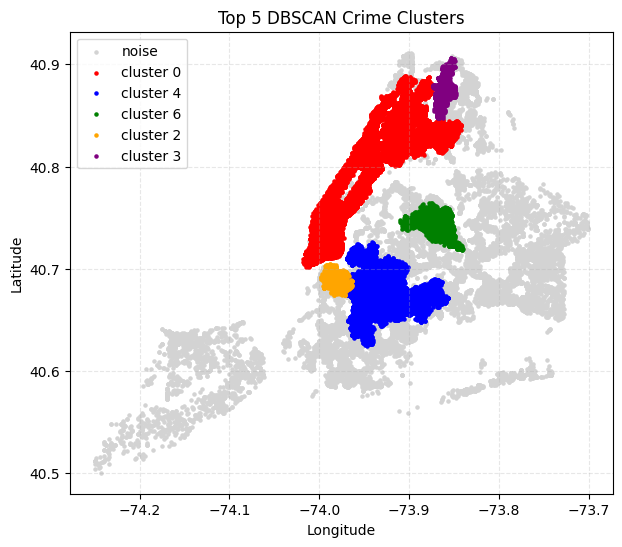

In [4]:
# top 5 clusters + noise

cluster_sizes = df_db[df_db['cluster'] != -1]['cluster'].value_counts()
top_clusters = cluster_sizes.head(5).index.tolist()

plt.figure(figsize=(7,6))

noise = df_db[df_db['cluster'] == -1]
plt.scatter(noise['lon'], noise['lat'], s=5, c='lightgray', label='noise')

colors = ['red','blue','green','orange','purple']  # for 5 clusters

for i, c in enumerate(top_clusters):
    subset = df_db[df_db['cluster'] == c]
    plt.scatter(subset['lon'], subset['lat'], s=5, color=colors[i], label=f'cluster {c}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 5 DBSCAN Crime Clusters')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [6]:
# Folium map for top DBSCAN clusters

import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

TOP_N = 8

cluster_counts = df_db[df_db['cluster'] != -1]['cluster'].value_counts()
top_clusters = cluster_counts.head(TOP_N).index.tolist()

center_lat = df_db['lat'].median()
center_lon = df_db['lon'].median()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

cmap = plt.get_cmap('tab10')
colors = [mcolors.to_hex(cmap(i % 10)) for i in range(TOP_N)]

noise = df_db[df_db['cluster'] == -1]
noise_group = folium.FeatureGroup(name=f"noise ({len(noise)})", show=False)

if len(noise) > 0:
    noise_sample = noise.sample(min(len(noise), 2000), random_state=1)
    for r in noise_sample.itertuples():
        folium.CircleMarker(
            location=(r.lat, r.lon),
            radius=1,
            color='#cccccc',
            fill=True,
            fill_opacity=0.4
        ).add_to(noise_group)

m.add_child(noise_group)

for i, c in enumerate(top_clusters):
    grp = folium.FeatureGroup(name=f"cluster {c} ({cluster_counts[c]})", show=(i == 0))
    subset = df_db[df_db['cluster'] == c]

    pts = subset.sample(min(len(subset), 3000), random_state=1)

    for r in pts.itertuples():
        folium.CircleMarker(
            location=(r.lat, r.lon),
            radius=2,
            color=colors[i],
            fill=True,
            fill_opacity=0.7
        ).add_to(grp)

    center = (subset['lat'].mean(), subset['lon'].mean())

    folium.CircleMarker(
        location=center,
        radius=8,
        color='black',
        fill=True,
        fill_color=colors[i],
        popup=f"cluster {c}\npoints: {cluster_counts[c]}",
        tooltip=f"cluster {c}"
    ).add_to(grp)

    m.add_child(grp)

folium.LayerControl(collapsed=False).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.